In [74]:
# Squidpy for getting dataset
import squidpy as sq
import pandas as pd
import spatialdm as sdm
import scanpy as sc
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, integrate
from joblib import Parallel, delayed
import tqdm
from scipy.signal import find_peaks

In [3]:
!which python

/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/bin/python


In [4]:
!pwd

/n/fs/ragr-research/users/hirak/Projects/copulacci/notebook/tutorial


In [5]:
from copulacci import cci
from copulacci import spatial
from copulacci import model
from copulacci import simulation
from copulacci import model2

In [6]:
EPSILON = 1.1920929e-07
from scipy import stats

def get_dt_cdf(x, lam, DT=True):
    u_x = stats.poisson.cdf(x, lam).clip(EPSILON, 1 - EPSILON)
    u_x2 = stats.poisson.cdf(x-1, lam).clip(EPSILON, 1 - EPSILON)
    if DT:
        v = stats.uniform.rvs(size=len(x))
        r = u_x * v + u_x2 * (1 - v)
    else:
        r = (u_x + u_x2) / 2.0
    #r = (u_x + u_x2) / 2.0
    #r = u_x2
    # remove too low / too big
    idx_adjust = np.where(1 - r < EPSILON)[0]
    r[ idx_adjust ] = r[ idx_adjust ] - EPSILON
    idx_adjust = np.where(r < EPSILON)[0]
    r[ idx_adjust ] = r[ idx_adjust ] + EPSILON
    return stats.norm.ppf(r)


def log_joint_lik_perm(params, umi_sum_1, umi_sum_2, x, y, perm=100, DT=True, model = 'copula', 
                       return_sum = True, remove_det = False):
    # get lam parameters for mu_1
    coeff = params[0]
    mu_1 = params[1]
    mu_2 = params[2]
    
    lam1 = umi_sum_1 * np.exp(mu_1)
    lam2 = umi_sum_2 * np.exp(mu_2)
    
    # get z
    r_x = get_dt_cdf(x, lam1, DT=DT)
    r_y = get_dt_cdf(y, lam2, DT=DT)
    if DT:
        for _ in range(perm-1):    
            r_x += get_dt_cdf(x, lam1)
            r_y += get_dt_cdf(y, lam2)
        z = np.column_stack([r_x/perm, r_y/perm])
    else:
        z = np.column_stack([r_x, r_y])
    
    # term1
    det = 1 - coeff**2
    if return_sum:
        term1 = np.sum(-0.5 * (((coeff**2)/det) * ((z[:,0]**2) + (z[:,1] ** 2)) - 2 * (coeff/det) * z[:,0] * z[:,1]) )
        term2 = (
            np.sum(np.log( stats.poisson.pmf(x, lam1).clip(EPSILON, 1 - EPSILON) )) +
            np.sum(np.log(stats.poisson.pmf(y, lam2).clip(EPSILON, 1 - EPSILON) ))
        )
        
        term3 = -0.5 * len(x) * np.log(det+EPSILON)
        if remove_det:
            logsum = term1 
        else:
            logsum = term1 + term2 + term3
    
        return -logsum
    else:
        term1 = -0.5 * (((coeff**2)/det) * ((z[:,0]**2) + (z[:,1] ** 2)) - 2 * (coeff/det) * z[:,0] * z[:,1])
        term2 = (
            np.log( stats.poisson.pmf(x, lam1).clip(EPSILON, 1 - EPSILON) ) + 
            np.log(stats.poisson.pmf(y, lam2).clip(EPSILON, 1 - EPSILON) )
        )
        term3 = -0.5 * np.log(det+EPSILON)
        return (term1 + term2 + term3)

In [7]:
import pickle
with open('../orator_paper_notebook/ISMB_submission_notebooks/simulation_folder/ismb_submission_simulated_data_24_1.pkl', 'rb') as file:
    data_list_check = pickle.load(file)

In [8]:
repro_df = pd.read_csv('../orator_paper_notebook/ISMB_submission_notebooks/simulation_folder/simulated_data_with_spearman_pearson.csv')

In [9]:
from math import sqrt
Parallel(n_jobs=2, prefer="threads")(
    delayed(sqrt)(i ** 2) for i in range(10))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [10]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)

opt_res = Parallel(n_jobs=20, verbose=1)(
    delayed(model2.call_optimizer)(
        x,
        y,
        _n_array,
        _n_array,
        copula_params,
        opt_params
    ) for (x,y,_,_,_n_array) in data_list_check)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   19.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  2.6min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  6.3min
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:  7.4min finished


In [11]:
cop_res = [opt_res[i][0] for i in range(len(opt_res))]
repro_df.loc[:, 'cop'] = cop_res
repro_df.loc[:, 'cop_method'] = [opt_res[i][3] for i in range(len(opt_res))]

In [12]:
repro_df.loc[repro_df.cop_method != 'copula']

,orig_index,sparse_frac,mu_x,mu_y,rho,zero_ratio,zz_ratio,spearman_log,pearson_log,cop,cop_method


In [13]:
def calculate_area(x,y,n_array,copula_params, opt_params):
    sx = np.log(x.sum() / n_array.sum())
    sy = np.log(y.sum() / n_array.sum())
    d2lik = model2.diff_using_num(sx,sy,n_array,n_array,x,y,copula_params,opt_params)
    s = np.sign(d2lik)
    x_train = np.linspace(-0.99, 0.99, 1000)
    ind_range = np.where(np.r_[s[:-1]!=s[1:], [False]])[0]
    if len(ind_range) == 0:
        return 0
    y = d2lik[ind_range[0]+1:ind_range[1]+1]
    return integrate.simpson(d2lik[ind_range[0]+1:ind_range[1]+1], dx=0.001)

In [21]:
def get_d1l(x,y,n_array,copula_params, opt_params):
    sx = np.log(x.sum() / n_array.sum())
    sy = np.log(y.sum() / n_array.sum())
    _, d1lik = model2.diff_using_num(sx,sy,n_array,n_array,x,y,copula_params,
                                         opt_params,do_first_order=True)
    s = np.sign(d1lik)
    ind_range = np.where(np.r_[s[:-1]!=s[1:], [False]])[0]
    
    return len(ind_range)

In [98]:
def get_peak_distance(x,y,n_array,copula_params, opt_params):
    sx = np.log(x.sum() / n_array.sum())
    sy = np.log(y.sum() / n_array.sum())
    _,d1lik = model2.diff_using_num(sx,sy,n_array,n_array,x,y,copula_params,
                                         opt_params,do_first_order=True)
    
    s = np.sign(d1lik)
    ind_range = np.where(np.r_[s[:-1]!=s[1:], [False]])[0]
    if len(ind_range) > 1:
        val = model2.only_log_lik(sx,sy,n_array,n_array,x,y,copula_params) 
        peaks, _ = find_peaks(-np.array(val))
        if len(peaks) > 0:
            diff = np.abs(val[peaks[0]] - val[peaks[1]])
            return diff
        return 0
    return 0

In [18]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)
d2l_neg_area = Parallel(n_jobs=20, verbose=1)(
        delayed(calculate_area)(
            x,
            y,
            _n_array,
            copula_params,
            opt_params
        ) for (x,y,_,_,_n_array) in data_list_check
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    9.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   10.4s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   11.9s
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:   12.5s finished


In [19]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)
d2l_other = Parallel(n_jobs=20, verbose=1)(
        delayed(model2.get_d2l_values)(
            x,
            y,
            _n_array,
            _n_array,
            copula_params,
            opt_params
        ) for (x,y,_,_,_n_array) in data_list_check
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 416 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 461 out of 500 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:    1.9s finished


In [22]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)
d1l_inflections = Parallel(n_jobs=20, verbose=1)(
        delayed(get_d1l)(
            x,
            y,
            _n_array,
            copula_params,
            opt_params
        ) for (x,y,_,_,_n_array) in data_list_check
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    9.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   10.6s
[Parallel(n_jobs=20)]: Done 420 tasks      | elapsed:   12.0s
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:   12.3s finished


In [23]:
repro_df['d2l_val'] = d2l_other
repro_df.loc[:, 'tot_area'] = d2l_neg_area
repro_df.loc[:, 'num_local_optima'] = d1l_inflections

In [99]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)
num_peaks = Parallel(n_jobs=20, verbose=1)(
        delayed(get_peak_distance)(
            x,
            y,
            _n_array,
            copula_params,
            opt_params
        ) for (x,y,_,_,_n_array) in data_list_check
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   10.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   12.3s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   14.2s
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:   14.8s finished


In [100]:
repro_df.loc[:, 'peak_diff'] = num_peaks

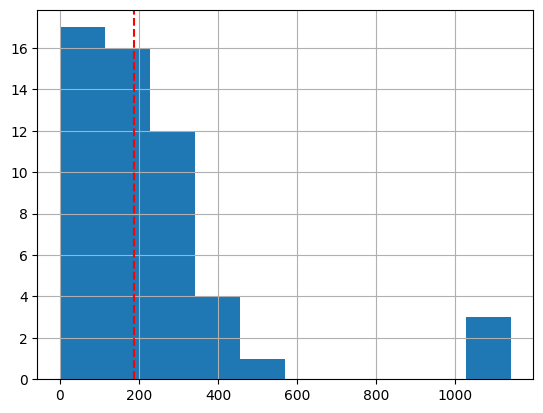

In [101]:
repro_df.loc[repro_df.peak_diff > 0].peak_diff.hist();
plt.axvline(repro_df.loc[27, 'peak_diff'],c='r',ls='--')

In [128]:
repro_df.loc[repro_df.peak_diff > 0].peak_diff.median()

166.06909935887893

In [119]:
repro_df.loc[27, 'peak_diff']

186.4039013258689

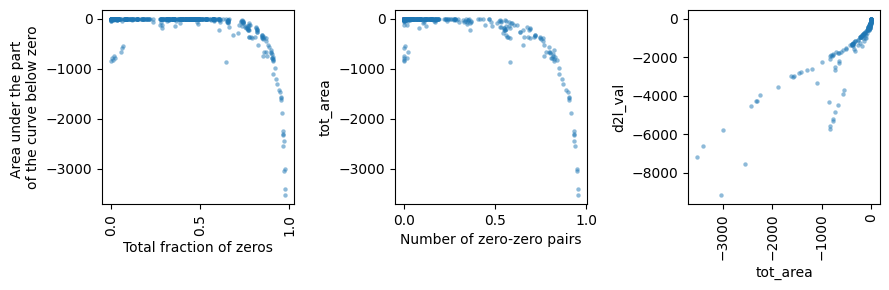

In [132]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
sns.scatterplot(
    data = repro_df,
    x = 'zero_ratio',
    y = 'tot_area',
    linewidth=0,
    s=10,
    alpha=0.5,
    ax=ax[0]
)

sns.scatterplot(
    data = repro_df,
    x = 'zz_ratio',
    y = 'tot_area',
    linewidth=0,
    s=10,
    alpha=0.5,
    ax=ax[1]
)

sns.scatterplot(
    data = repro_df.loc[repro_df.d2l_val < 0],
    x = 'tot_area',
    y = 'd2l_val',
    linewidth=0,
    s=10,
    alpha=0.5,
    ax=ax[2]
)

fig.subplots_adjust(wspace=0.2, hspace=0.2)
ax[0].set_xlabel('Total fraction of zeros')
ax[0].set_ylabel('Area under the part \nof the curve below zero')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xlabel('Number of zero-zero pairs')
plt.xticks(rotation=90) 
plt.tight_layout()

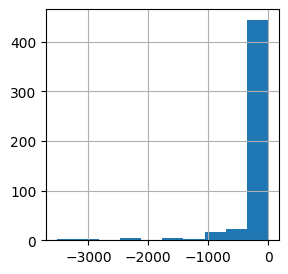

In [112]:
plt.figure(figsize=(3,3))
repro_df.tot_area.hist();

In [38]:
import matplotlib.lines as mlines
from matplotlib.collections import PathCollection
from matplotlib.lines import Line2D

def check_lik(index,ymin=-1000,ymax=50000):
    x,y,_,_,n_array = data_list_check[index]
    x_train = np.linspace(-0.99, 0.99, 1000)
    lik = []
    likf = []
    d2lik = []
    sx = np.log(x.sum() / n_array.sum())
    sy = np.log(y.sum() / n_array.sum())
    umi_sums_x = n_array
    umi_sums_y = n_array
    # for i in x_train:
    #     likf+=[log_joint_lik_perm(
    #         [i, sx, sy], 
    #         umi_sums_x,
    #         umi_sums_y,
    #         x, 
    #         y, 
    #         perm=1, 
    #         DT=False, 
    #         model = 'copula', 
    #         return_sum = True
    #     )]
    #d2lik = model2.diff_using_num(sx,sy,n_array,n_array,x,y,copula_params,opt_params)
    likf = model2.only_log_lik(sx,sy,n_array,n_array,x,y,copula_params)
    d2lik, d1lik = model2.diff_using_num(sx,sy,n_array,n_array,x,y,
                                         copula_params,opt_params,x_train=x_train, do_first_order=True)
    
    plt.scatter(x_train, likf, s=3, alpha=0.6, linewidth=0, c='b',label = r'$L$')
    plt.scatter(x_train, d1lik, s=3, alpha=0.6, linewidth=0, c='g',label =  r'$\frac{\partial L}{\partial \rho}$')
    plt.scatter(x_train, d2lik, s=3, alpha=0.6, linewidth=0, c='r',label = r'$\frac{\partial^2 L}{\partial \rho^2}$' )
    plt.axhline(0, color='red', linestyle='--');
    
    plt.ylim(ymin, ymax);
    plt.show()
    return d1lik



def get_area(d2lik):
    s = np.sign(d2lik)
    x_train = np.linspace(-0.99, 0.99, 1000)
    ind_range = np.where(np.r_[s[:-1]!=s[1:], [False]])[0]
    if len(ind_range) == 0:
        return 0
    y = d2lik[ind_range[0]+1:ind_range[1]+1]
    return integrate.simpson(d2lik[ind_range[0]+1:ind_range[1]+1], dx=0.001)

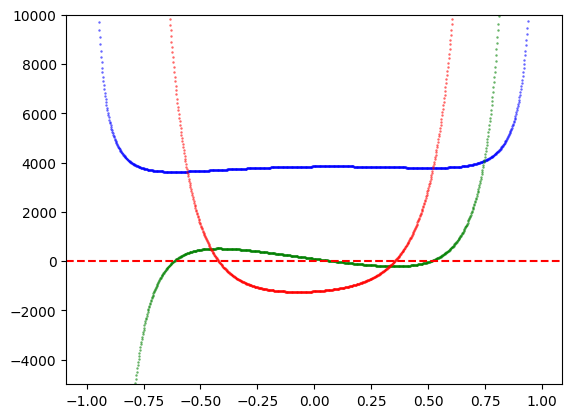

array([4.97689537])

In [122]:
d1lik = check_lik(17,-5000,10000)
d1lik[((d1lik<5) & (d1lik>-5))]

In [62]:
d1lik[((d1lik<5) & (d1lik>-5))]

array([-2.11671015, -0.44662435])

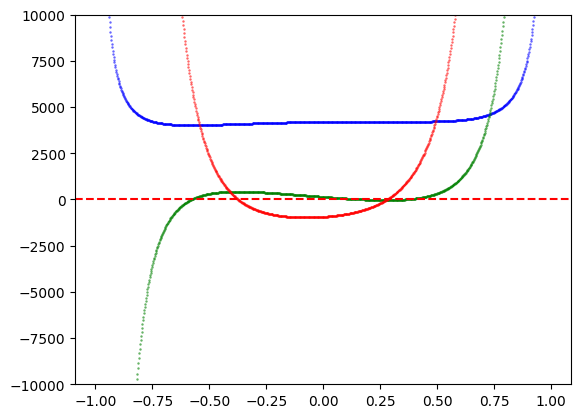

In [72]:
d1lik = check_lik(27, -10000,10000)

In [72]:
s = np.sign(d2lik)

In [73]:
x_train[np.r_[s[:-1]!=s[1:], [False]]]

array([0.35576577, 0.5281982 ])

In [74]:
ind_range = np.where(np.r_[s[:-1]!=s[1:], [False]])[0]

In [75]:
ind_range

array([679, 766])

In [76]:
d2lik[766]

-7.0071472141980555

In [84]:
d2lik[ind_range[0]+1:ind_range[1]+1]

array([  -2.71216327,  -12.36913939,  -21.89433295,  -31.28612014,
        -40.542824  ,  -49.66271274,  -58.64400172,  -67.48484798,
        -76.18335141,  -84.73755363,  -93.14543557, -101.40491531,
       -109.51384982, -117.47002922, -125.27117815, -132.91495342,
       -140.398943  , -147.72066116, -154.87755198, -161.86698251,
       -168.68624562, -175.33255115, -181.8030347 , -188.09474343,
       -194.20464285, -200.12961203, -205.86643818, -211.41182122,
       -216.76236396, -221.91457475, -226.86486395, -231.60953838,
       -236.14480547, -240.46676044, -244.57139453, -248.45458435,
       -252.11209001, -255.53955776, -258.73250706, -261.68633784,
       -264.39631771, -266.85758609, -269.06514568, -271.01386081,
       -272.69845366, -274.113499  , -275.25342252, -276.11249485,
       -276.68482561, -276.9643653 , -276.9448917 , -276.62001349,
       -275.98316093, -275.0275785 , -273.74632965, -272.13227643,
       -270.17808906, -267.87623049, -265.21895245, -262.19829

In [78]:
x_train[1] - x_train[0]

0.0019819819819819617

In [79]:
from scipy import integrate

In [80]:
integrate.simpson(d2lik[ind_range[0]+1:ind_range[1]+1], dx=0.001)

-15.93519710619877

In [175]:
def compare_methods(results_filt):
    bins = [0,0.1,0.3,0.6,0.9]
    results_filt.loc[:, 'rho_bucket'] = pd.cut(abs(results_filt.rho), bins=bins,
                    include_lowest=True,
                    labels = ['<10%','10%-30%','30%-60%','70%-90%'])
    bins = [0,0.1,0.3,0.7,1]
    labels = ['<10%','10%-30%', '30%-50%','50%-100%']
    results_filt.loc[:, 'zr_cat'] = pd.cut(results_filt.zero_ratio, bins=bins,
                    include_lowest=True,
                    labels = labels
                    )

    if ('zz_ratio' in results_filt.columns ):
        results_filt.loc[:, 'zz_cat'] = pd.cut(results_filt.zz_ratio, bins=bins,
                        include_lowest=True,
                        labels = labels)
        
        res_filt_melt = pd.melt(
            results_filt, 
            id_vars = ['rho','rho_bucket','sparse_frac','zr_cat','zz_cat'],
            value_vars = ['spearman_log', 'pearson_log' , 'cop'],
            var_name = 'method', value_name = 'value'
        )
        
        res_focus = results_filt.copy()
        for col in ['spearman_log', 'pearson_log', 'cop',]:
            res_focus.loc[:, col+'_diff'] = res_focus.rho - res_focus[col]
        
        res_focus_melt = pd.melt(
            res_focus, 
            id_vars = ['rho','rho_bucket','sparse_frac','zr_cat','zz_cat'],
            value_vars = ['spearman_log_diff', 'pearson_log_diff', 'cop_diff'],
            var_name = 'method', value_name = 'difference'
        )
    else:
        res_filt_melt = pd.melt(
            results_filt, 
            id_vars = ['rho','rho_bucket','sparse_frac','zr_cat'],
            value_vars = ['spearman_log', 'pearson_log' , 'cop'],
            var_name = 'method', value_name = 'value'
        )
        
        res_focus = results_filt.copy()
        for col in ['spearman_log', 'pearson_log', 'cop',]:
            res_focus.loc[:, col+'_diff'] = res_focus.rho - res_focus[col]
        
        res_focus_melt = pd.melt(
            res_focus, 
            id_vars = ['rho','rho_bucket','sparse_frac','zr_cat'],
            value_vars = ['spearman_log_diff', 'pearson_log_diff', 'cop_diff'],
            var_name = 'method', value_name = 'difference'
        )
    
    plt.figure(figsize=(10, 5))
    #figure_backup = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures'
    
    #tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_norm_diff', 'spearman_log_norm_diff'])]
    label_dict = { 'cop_diff' : 'Copula', 'spearman_diff': 'Spearman', 'pearson_diff' : 'Pearson', 
                  'spearman_log_diff': 'Spearman on log normalized data',
                  'pearson_log_diff' : 'Pearson on log normalized data'}
    sns.stripplot(x="zr_cat", y="difference", hue="method",
                  data=res_focus_melt ,
                  jitter=True,
                  palette='dark:black',
                  legend = None,
                  hue_order=['cop_diff', 'spearman_log_diff', 'pearson_log_diff'],
                  #palette="Set5", 
                  alpha = 0.4,
                  dodge=True,
                  linewidth=0,
                  edgecolor='gray',
                 order = labels[::-1])
    
    sns.boxplot(x="zr_cat", y="difference", hue="method",
                data=res_focus_melt,
                #palette="Set5",
                hue_order=['cop_diff','spearman_log_diff', 'pearson_log_diff'],
                fliersize=0, 
                order = labels[::-1]
               )
    
    plt.xlabel('', fontsize = 10)
    plt.ylabel('Correlation coefficient difference from truth', fontsize = 10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=15)
    plt.axhline(y=0, c = 'r', linewidth = 1, linestyle='--')
    
    
    #leg = plt.gca().get_legend()
    leg = plt.legend(
        title="Methods",
                     loc='right', bbox_to_anchor=(1.4,0.5),
              frameon=False);
    
    # Replace the legend labels using the custom handler
    for text, handle in zip(leg.texts, leg.legend_handles):
        text.set_text(label_dict.get(text.get_text(), text.get_text()))
    
    plt.setp(leg.texts, fontsize='10')
    sns.despine()
    # plt.savefig( os.path.join(figure_backup,
    #                            'non_spatial_simulation_copula_1_24_24_buckets.pdf'), dpi = 300, bbox_inches='tight')
    plt.show()

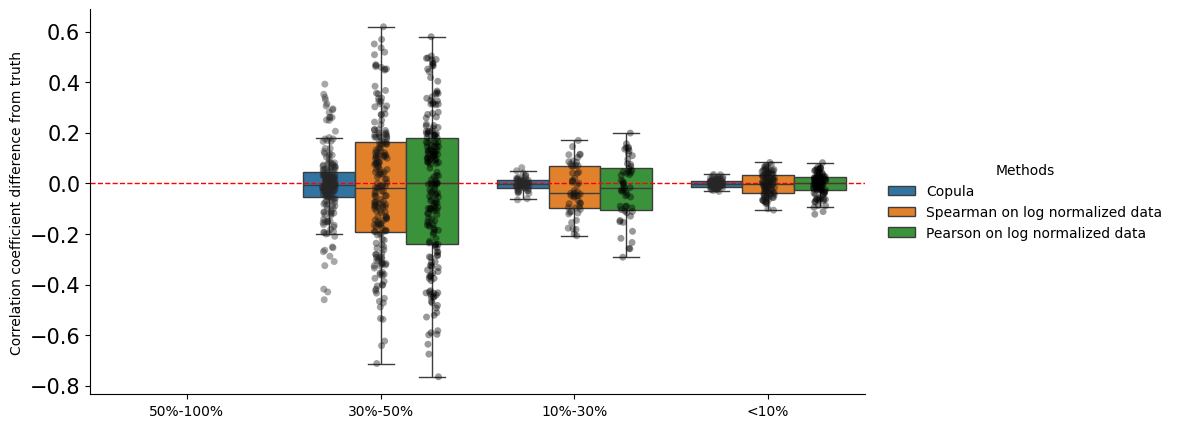

(340, 18)


In [141]:
# cop_res = [opt_res[i][0] for i in range(len(opt_res))]
# repro_df.loc[:, 'cop'] = cop_res
# repro_df.loc[:, 'cop_method'] = [opt_res[i][3] for i in range(len(opt_res))]
results_filt = repro_df.loc[repro_df.d2l_val >0].copy()
compare_methods(results_filt)
print(results_filt.shape)

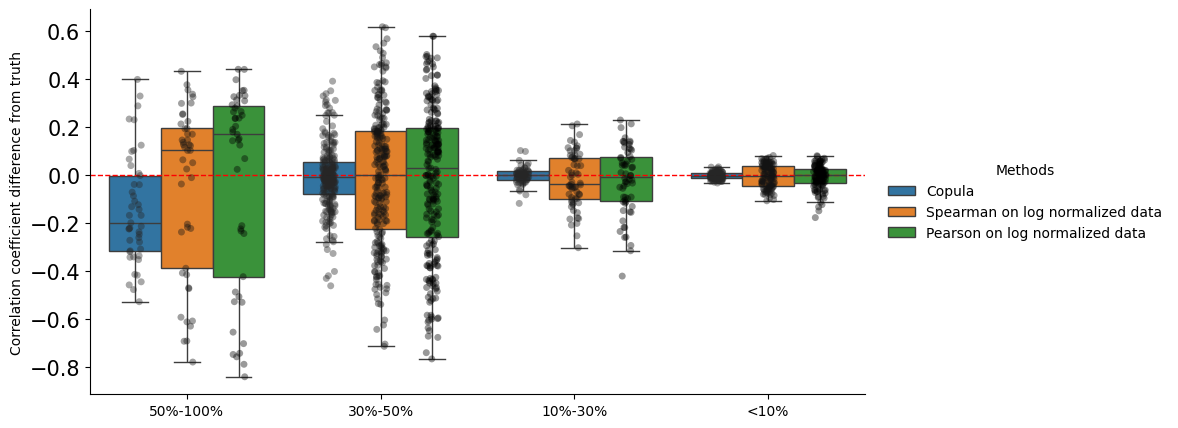

(462, 18)


In [151]:
# cop_res = [opt_res[i][0] for i in range(len(opt_res))]
# repro_df.loc[:, 'cop'] = cop_res
#repro_df.loc[:, 'cop_method'] = [opt_res[i][3] for i in range(len(opt_res))]
results_filt = repro_df.loc[((repro_df.num_local_optima == 1) | (repro_df.peak_diff > 300))].copy()
compare_methods(results_filt)
print(results_filt.shape)

In [140]:
results_filt.groupby('zr_cat').count()

,orig_index,sparse_frac,mu_x,mu_y,rho,zero_ratio,zz_ratio,spearman_log,pearson_log,cop,cop_method,d2l_val,tot_area,num_local_optima,peak_diff,rho_bucket,zz_cat
zr_cat,,,,,,,,,,,,,,,,,
<10%,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114
10%-30%,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62,62
30%-50%,241,241,241,241,241,241,241,241,241,241,241,241,241,241,241,241,241
50%-100%,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51


In [134]:
repro_df

,orig_index,sparse_frac,mu_x,mu_y,rho,zero_ratio,zz_ratio,spearman_log,pearson_log,cop,cop_method,d2l_val,tot_area,num_local_optima,peak_diff,rho_bucket,zr_cat,zz_cat
0,1,0.1,-11.725074,-11.358757,-0.8,0.976567,0.953133,-0.023839,-0.011854,-0.908983,copula,-5760.799600,-3004.056361,3,72.512659,70%-90%,50%-100%,50%-100%
1,6,0.1,-11.725074,-11.358757,-0.3,0.979068,0.958136,-0.020503,-0.011453,-0.922094,copula,-7161.343846,-3530.457297,3,71.311690,10%-30%,50%-100%,50%-100%
2,22,0.1,-11.725074,-10.684445,-0.6,0.967483,0.934966,-0.030782,-0.013419,-0.887552,copula,-4263.714966,-2328.149479,3,93.337017,30%-60%,50%-100%,50%-100%
3,23,0.1,-11.725074,-10.684445,-0.5,0.968273,0.936546,-0.028329,-0.016907,-0.892925,copula,-4509.014834,-2442.428715,3,94.824016,30%-60%,50%-100%,50%-100%
4,35,0.1,-11.725074,-10.684445,0.7,0.963797,0.939442,0.344274,0.301692,0.935423,copula,-7523.217096,-2556.012436,3,1111.463781,70%-90%,50%-100%,50%-100%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,7563,1.0,-5.157114,-5.407721,-0.8,0.000132,0.000000,-0.768650,-0.798797,-0.804648,copula,-473.302014,-34.209979,1,0.000000,70%-90%,<10%,<10%
496,7566,1.0,-5.157114,-5.407721,-0.5,0.000000,0.000000,-0.464088,-0.516395,-0.505205,copula,2546.656328,0.000000,1,0.000000,30%-60%,<10%,<10%
497,7569,1.0,-5.157114,-5.407721,-0.2,0.000000,0.000000,-0.177672,-0.159676,-0.183378,copula,3602.610876,0.000000,1,0.000000,10%-30%,<10%,<10%
498,7577,1.0,-5.157114,-5.407721,0.6,0.000000,0.000000,0.550298,0.575117,0.595542,copula,2193.976002,0.000000,1,0.000000,30%-60%,<10%,<10%


In [212]:
results_filt.shape

(394, 16)

In [213]:
tmp = repro_df.loc[(repro_df.tot_area > -50) & (repro_df.tot_area < 0)].sort_values(['tot_area'])

In [214]:
tmp['cop_diff'] = tmp['rho'] - tmp['cop']

In [227]:
tmp.sort_values(['cop_diff'], ascending=False)[['zz_ratio',
                                                'rho',
                                                'tot_area',
                                                'spearman_log','cop']]

,zz_ratio,rho,tot_area,spearman_log,cop
56,0.520537,0.0,-44.554192,0.036150,-0.399456
30,0.169563,0.9,-24.400316,0.285260,0.587841
376,0.531069,-0.3,-44.429648,-0.096848,-0.534484
264,0.238810,0.9,-49.585886,0.409145,0.675547
288,0.000000,0.9,-0.085935,0.548022,0.705851
128,0.337019,-0.3,-42.106795,-0.064167,-0.458053
474,0.001053,0.9,-25.432781,0.630623,0.757429
446,0.005003,0.9,-34.640066,0.634602,0.762275
153,0.276198,0.8,-33.292150,0.413156,0.665754
183,0.285677,0.7,-28.063288,0.306003,0.596516


In [273]:
repro_df.loc[(repro_df.rho == 0.9) & (repro_df.zz_ratio == 0)]

,orig_index,sparse_frac,mu_x,mu_y,rho,zero_ratio,zz_ratio,spearman_log,pearson_log,cop,cop_method,tot_area,d2l_val
288,4559,0.5,-10.493394,-4.583444,0.9,0.38178,0.0,0.548022,0.527275,0.705851,copula,-0.085935,-7.016992


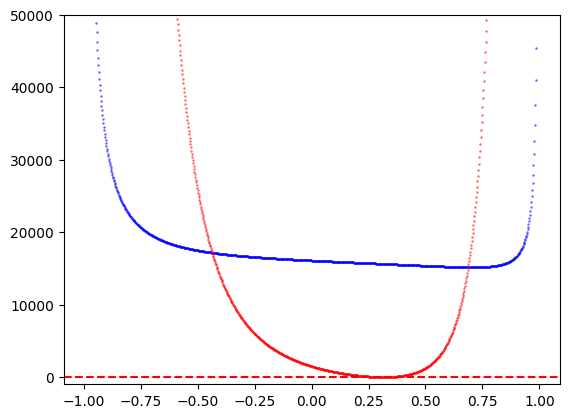

-0.08593471531300068


In [275]:
d2lik = check_lik(288, -1000,50000)
print(get_area(d2lik))

In [7]:
d2l_values_df = pd.DataFrame()

copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)
d2l_other = Parallel(n_jobs=20, verbose=1)(
        delayed(model2.get_d2l_values)(
            x,
            y,
            _n_array,
            _n_array,
            copula_params,
            opt_params
        ) for (x,y,_,_,_n_array) in data_list_check
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    9.7s
[Parallel(n_jobs=20)]: Done 202 tasks      | elapsed:   10.5s
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:   11.1s finished


In [229]:
import pickle as pk
starmap_dataset = pk.load(
    open('/n/fs/ragr-research/projects/network-mutations/copulacci/sagittal1_copulacci_input.pickle','rb')
)

In [230]:
starmap_dataset.keys()

dict_keys(['data_list_dict', 'umi_sums', 'data_list_dict_close', 'umi_sums_close'])

In [238]:
data_list = starmap_dataset['data_list_dict'][
    'Telencephalon projecting excitatory neurons=Astrocytes'
]
umi_sums = starmap_dataset['umi_sums'][
    'Telencephalon projecting excitatory neurons=Astrocytes'
]
umi_sums_x = umi_sums['Telencephalon projecting excitatory neurons']
umi_sums_y = umi_sums['Astrocytes']

In [286]:
def check_lik_real_data(
    x,
    y,
    umi_sums_x,
    umi_sums_y,
    ymin=-1000,ymax=50000
):
    x_train = np.linspace(-0.99, 0.99, 1000)
    sx = np.log(x.sum() / umi_sums_x.sum())
    sy = np.log(y.sum() / umi_sums_y.sum())
    likf = []
    for i in x_train:
        likf+=[log_joint_lik_perm(
            [i, sx, sy], 
            umi_sums_x,
            umi_sums_y,
            x, 
            y, 
            perm=1, 
            DT=False, 
            model = 'copula', 
            return_sum = True
        )]
    d2lik = model2.diff_using_num(sx,sy,
                                  umi_sums_x,
                                  umi_sums_y,
                                  x,y,copula_params,opt_params)
    plt.scatter(x_train, likf, s=3, alpha=0.6, linewidth=0, c='b',label = r'$L$')
    plt.scatter(x_train, d2lik, s=3, alpha=0.6, linewidth=0, c='r',label = r'$\frac{\partial^2 L}{\partial \rho^2}$' )
    plt.axhline(0, color='red', linestyle='--');
    
    plt.ylim(ymin, ymax);
    plt.show()
    return d2lik

array([90, 65, 69, ..., 54, 40, 40])

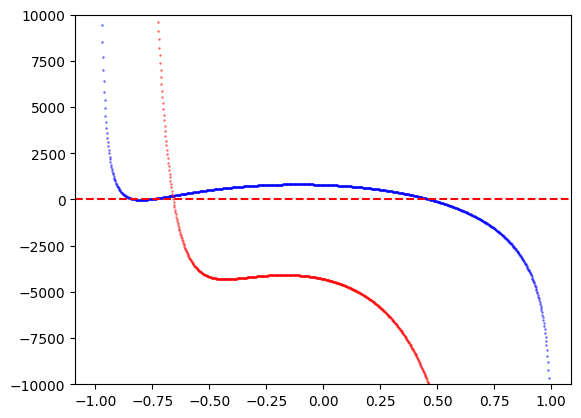

IndexError: index 1 is out of bounds for axis 0 with size 1

In [291]:
d2lik = check_lik_real_data(
    data_list[0][0].astype(int),
    data_list[0][0].astype(int),
    umi_sums_x.astype(int),
    umi_sums_y.astype(int),
    -10000,
    10000
)

print(get_area(d2lik))

In [278]:
umi_sums_x

array([90.12485 , 65.42677 , 69.95863 , ..., 54.543144, 40.374496,
       40.374496], dtype=float32)

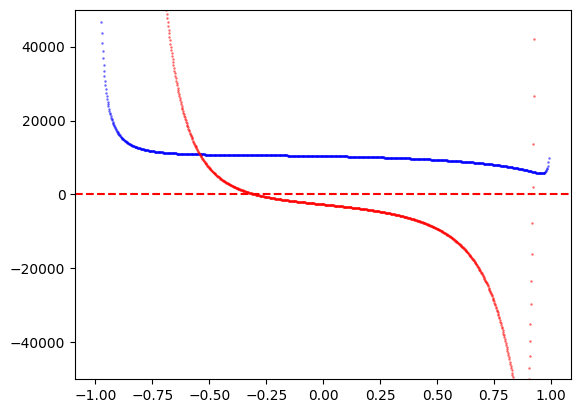

-7430.280058303994


In [277]:
x = np.array([1]*len(data_list[0][0]))
x[1:1000] = 0
y = x.copy()
y[5000:] =0
d2lik = check_lik_real_data(
    x,
    y,
    umi_sums_x,
    umi_sums_y,
    -50000,
    50000
)

print(get_area(d2lik))

In [284]:
idx = 0
x = data_list[idx][0]
y = data_list[idx][1] 
df = pd.DataFrame(np.vstack([x,y,umi_sums_x, umi_sums_y]).T, columns=['x', 'y', 'umi_sum_x', 'umi_sum_y'])

In [285]:
df.to_csv('../../notebook/orator_paper_notebook/notebook_reevaluation/sagittal_starmap_0.csv')

In [293]:
df = df.astype(int)

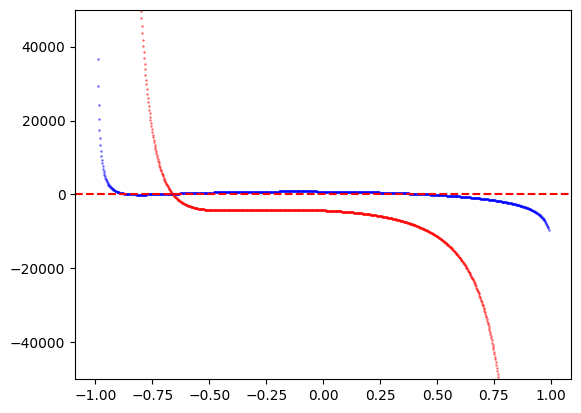

In [296]:
d2lik = check_lik_real_data(
    df.x.values,
    df.x.values,
    df.umi_sum_x.values,
    df.umi_sum_y.values,
    -50000,
    50000
)

In [259]:
idx = 0
x = data_list[idx][0]
y = data_list[idx][1]

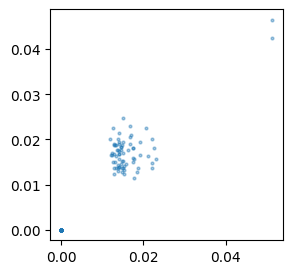

In [295]:
plt.figure(figsize=(3,3))
plt.scatter(np.log(df.x/df.umi_sum_x + 1), np.log(x/df.umi_sum_y + 1), s=4,alpha=0.4)

In [261]:
stats.spearmanr(np.log(x/umi_sums_x + 1), np.log(y/umi_sums_y + 1))

SignificanceResult(statistic=-0.007750949716219699, pvalue=0.5750878957094779)

In [264]:
(x>0).sum()/len(x)

0.01375883814255685

In [265]:
(y>0).sum()/len(x)

0.024460156697878845

In [266]:
len(x)

5233

In [12]:
repro_df['d2l_val'] = d2l_other

In [20]:
repro_df['stable'] = False
repro_df.loc[repro_df.d2l_val >= 0, 'stable'] = True

<Axes: xlabel='zero_ratio', ylabel='d2l_val'>

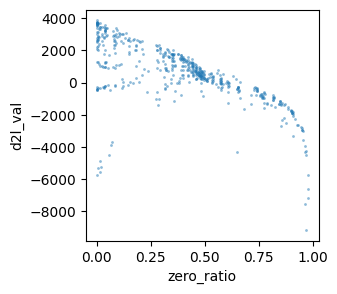

In [25]:
plt.figure(figsize=(3,3))
sns.scatterplot(data = repro_df, x = 'zero_ratio', y = 'd2l_val', s = 4, 
                linewidth=0, alpha=0.5)

In [56]:
bins = [0,0.1,0.3,0.6,0.9]

# Only take where copula was run
results_filt = repro_df

results_filt.loc[:, 'rho_bucket'] = pd.cut(abs(results_filt.rho), bins=bins,
                include_lowest=True,
                labels = ['<10%','10%-30%','30%-60%','70%-90%'])
bins = [0,0.2,0.4,0.6,0.8,1]
labels = ['<20%','20%-40%','40%-60%','60%-80%','80%-100%']
results_filt.loc[:, 'zr_cat'] = pd.cut(results_filt.zero_ratio, bins=bins,
                include_lowest=True,
                labels = labels
                )
results_filt.loc[:, 'zz_cat'] = pd.cut(results_filt.zz_ratio, bins=bins,
                include_lowest=True,
                labels = labels)

In [77]:
counts = results_filt.groupby(['zr_cat', 'stable'])['stable'].value_counts()
df1 = results_filt.groupby(['zr_cat', 'stable'])['stable'].value_counts().reset_index()
df1['stable_frac'] = counts.groupby(level=0).apply(lambda x:  x / float(x.sum())).values

In [79]:
counts = results_filt.groupby(['zz_cat', 'stable'])['stable'].value_counts()
df2 = results_filt.groupby(['zz_cat', 'stable'])['stable'].value_counts().reset_index()
df2['stable_frac'] = counts.groupby(level=0).apply(lambda x:  x / float(x.sum())).values

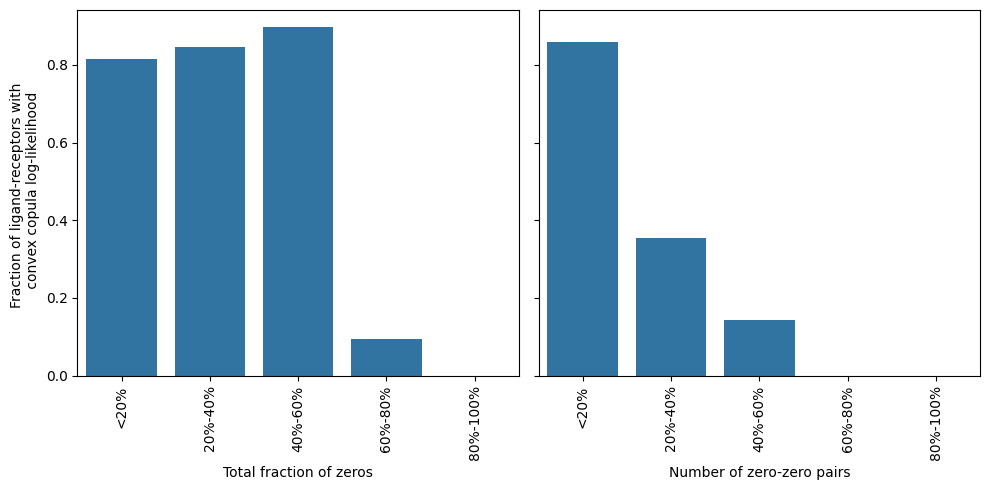

In [113]:
fig, ax = plt.subplots(1,2, figsize=(10,5),sharey=True)
sns.barplot(
    data = df1.loc[df1.stable],
    x = 'zr_cat',
    y = 'stable_frac',
    ax=ax[0]
)

sns.barplot(
    data = df2.loc[df2.stable],
    x = 'zz_cat',
    y = 'stable_frac',
    ax=ax[1]
)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
ax[0].set_xlabel('Total fraction of zeros')
ax[0].set_ylabel('Fraction of ligand-receptors with \n convex copula log-likelihood')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xlabel('Number of zero-zero pairs')
plt.xticks(rotation=90) 
plt.tight_layout()

<Axes: xlabel='zr_cat', ylabel='stable_frac'>

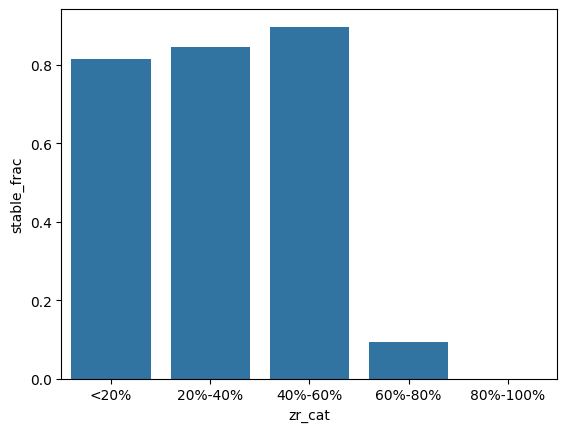

In [97]:
sns.barplot(data=df1.loc[df1.stable], x = 'zr_cat', y='stable_frac')

In [54]:
counts = results_filt.groupby(['zr_cat', 'stable'])['stable'].value_counts()

In [55]:
counts.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

zr_cat    zr_cat    stable
<10%      <10%      False     21.052632
                    True      78.947368
10%-30%   10%-30%   False     14.516129
                    True      85.483871
30%-100%  30%-100%  False     39.197531
                    True      60.802469
Name: count, dtype: float64

-----------------------------------------------------------------------

## Simulate extreme correlations

In [298]:
adata = sq.datasets.visium(sample_id='V1_Breast_Cancer_Block_A_Section_1')

  0%|          | 0.00/9.50M [00:00<?, ?B/s]

  0%|          | 0.00/26.9M [00:00<?, ?B/s]

In [300]:
annotation_meta = pd.read_csv(
    'data/Human_Breast_Cancer_Metadata.tsv',
    sep = '\t',
    index_col=0
)
adata.obs = adata.obs.join(annotation_meta)
n_array_sum = adata.to_df().sum(1)
adata.var_names_make_unique()
adata_sdm = adata.copy()
sc.pp.normalize_total(adata_sdm, target_sum=None)
sc.pp.log1p(adata_sdm)
sdm.extract_lr(adata_sdm, 'human', min_cell=20)
df_lig_rec_linear = cci.extract_lig_rec_from_sdm(adata_sdm, allow_same_lr=True)
chosen_lr = list(set( df_lig_rec_linear.ligand.unique()).union(
    set( df_lig_rec_linear.receptor.unique() )
))
count_df = adata.to_df().loc[:,chosen_lr]
adata.obs['celltype'] = adata.obs.annot_type
adata_sdm.obs['celltype'] = adata.obs.annot_type
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata_sdm
)
lig_list = adata_sdm.uns['ligand'].values
rec_list = adata_sdm.uns['receptor'].values
df_lig_rec = pd.concat(
   [ adata_sdm.uns['ligand'], adata_sdm.uns['receptor']],
    axis = 1
)
data_list_dict, umi_sums, dist_list_dict = spatial.prepare_data_list(
    count_df,
    int_edges_with_selfloop,
    heteromeric=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization='sum'
)

Constructing spatial network with visium


100%|██████████| 16/16 [01:01<00:00,  3.82s/it]


In [153]:
data_list_dict.keys()

dict_keys(['Surrounding tumor=Surrounding tumor', 'Invasive=Invasive', 'Healthy=Healthy', 'Tumor=Tumor', 'Surrounding tumor=Invasive', 'Invasive=Surrounding tumor', 'Tumor=Invasive', 'Invasive=Tumor', 'Tumor=Surrounding tumor', 'Surrounding tumor=Tumor', 'Healthy=Surrounding tumor', 'Surrounding tumor=Healthy', 'Healthy=Invasive', 'Invasive=Healthy', 'Tumor=Healthy', 'Healthy=Tumor'])

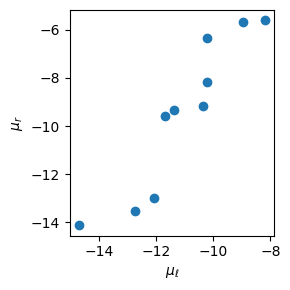

In [206]:
np.random.seed(2)
mu_x_vals = np.random.uniform(-15, -4, 10)
mu_y_vals = np.random.uniform(-15, -4, 10)
mu_x_vals = sorted(mu_x_vals)
mu_y_vals = sorted(mu_y_vals)
plt.figure(figsize=(3,3))
plt.scatter(mu_x_vals, mu_y_vals)
plt.xlabel('$\mu_\ell$')
plt.ylabel('$\mu_r$');
plt.tight_layout();

In [225]:
grid_points_df = simulation.create_param_grid(
    rho_vec = np.linspace(-0.99, 0.99, 19),
    sparse_fraction = np.array([0.05, 0.1, 0.2, 0.4]),
    mu_x_vec = mu_x_vals, 
    mu_y_vec = mu_y_vals
)

In [238]:
grid_points_df_sampled = grid_points_df.sample(1000).sort_index()

In [239]:
pseudo_count = pd.DataFrame()
for row in tqdm.tqdm(grid_points_df_sampled.iterrows()):
    sparse_frac, mu_x, mu_y, rho, global_idx = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    
    
    sample = model2.sample_from_copula(
        _n_array,
        mu_x, 
        mu_y, 
        coeff = rho
    )
    sample.columns = ['L'+str(int(global_idx)), 'R'+str(int(global_idx))]
    pseudo_count = pd.concat([pseudo_count, sample.copy()], axis = 1)

1000it [00:28, 34.86it/s]


In [247]:
zero_indices = pseudo_count.sum(0)[pseudo_count.sum(0) == 0].index.str[1:]

In [256]:
columns_to_remove = list('L' + zero_indices) + list('R' + zero_indices)

In [260]:
pseudo_count = pseudo_count.drop(columns_to_remove, axis = 1)

In [271]:
grid_points_df_sampled = grid_points_df_sampled.drop(zero_indices.astype(int), axis=0)

In [272]:
idx = 0
sum_cols = []
for i in range(0, len(pseudo_count.columns), 2):
    # Extract the current and next columns
    current_col = np.concatenate([pseudo_count.iloc[:, i].values, 
                                  pseudo_count.iloc[:, i+1].values])

    # Calculate the sum of the two consecutive columns
    sum_cols += [pd.DataFrame(current_col, columns = ['LR'+str(idx)])]
    idx += 1

In [273]:
sparse_res_df = pd.concat(sum_cols, axis = 1)
results_df = grid_points_df_sampled.copy()
results_df.loc[:,'zero_ratio'] = (sparse_res_df == 0).mean().values

In [274]:
data_list = []
i = 0
for row in tqdm.tqdm(grid_points_df_sampled.iterrows()):
    sparse_frac, mu_x, mu_y, rho, i = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list += [
        (
            pseudo_count.loc[:, 'L'+str(int(i))].values.astype('int'),
            pseudo_count.loc[:, 'R'+str(int(i))].values.astype('int'),
            mu_x, mu_y,
            _n_array.copy()
            
        )
    ]

992it [00:00, 1748.57it/s]


In [275]:
count_df_norm = pseudo_count.div(pseudo_count.sum(1), axis = 0) 
count_df_norm_log = np.log( count_df_norm + 1 )
data_list_log = []
for row in tqdm.tqdm(grid_points_df_sampled.iterrows()):
    sparse_frac, mu_x, mu_y, rho, i = row[1]
    data_list_log += [
        (
            count_df_norm_log.loc[:, 'L'+str(int(i))],
            count_df_norm_log.loc[:, 'R'+str(int(i))]
        )
    ]
spr = []
for (x,y) in data_list_log:
    spr += [stats.spearmanr(x, y).correlation]
prs = []
for (x,y) in data_list_log:
    prs += [stats.pearsonr(x, y).correlation]

992it [00:00, 1362.98it/s]


In [276]:
data_list[6][0].sum()

1

In [277]:
stats.spearmanr(data_list[6][0], data_list[6][1])

SignificanceResult(statistic=-0.0005892143051439221, pvalue=0.9710430703205867)

In [278]:
results_df = results_df.reset_index().rename(columns={'index':'orig_index'})

In [279]:
results_df

,orig_index,sparse_frac,mu_x,mu_y,rho,ind,zero_ratio
0,0,0.05,-14.714811,-14.123900,-0.99,0,0.998947
1,1,0.05,-14.714811,-14.123900,-0.88,1,0.999473
2,9,0.05,-14.714811,-14.123900,0.00,9,0.999210
3,21,0.05,-14.714811,-13.519621,-0.77,21,0.999473
4,22,0.05,-14.714811,-13.519621,-0.66,22,0.999473
...,...,...,...,...,...,...,...
987,7550,0.40,-8.188019,-6.361313,-0.22,7550,0.107425
988,7560,0.40,-8.188019,-6.361313,0.88,7560,0.109136
989,7561,0.40,-8.188019,-6.361313,0.99,7561,0.112164
990,7584,0.40,-8.188019,-5.606272,-0.66,7584,0.103081


In [307]:
import importlib
importlib.reload(model2)

<module 'copulacci.model2' from '/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py'>

In [285]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=50)

opt_res_convex_3_params = Parallel(n_jobs=20, verbose=1)(
    delayed(model2.call_optimizer)(
        x,
        y,
        _n_array,
        _n_array,
        copula_params,
        opt_params,
        stability_filter = True
    ) for (x,y,_,_,_n_array) in data_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    9.3s
[Parallel(n_jobs=20)]: Done 184 tasks      | elapsed:   11.1s
[Parallel(n_jobs=20)]: Done 643 tasks      | elapsed:   18.4s
[Parallel(n_jobs=20)]: Done 992 out of 992 | elapsed:   29.5s finished


In [286]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=50)

opt_res_convex = Parallel(n_jobs=20, verbose=1)(
    delayed(model2.call_optimizer)(
        x,
        y,
        _n_array,
        _n_array,
        copula_params,
        opt_params,
        stability_filter = True,
        quick = True
    ) for (x,y,_,_,_n_array) in data_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 750 tasks      | elapsed:   12.7s
[Parallel(n_jobs=20)]: Done 992 out of 992 | elapsed:   21.3s finished


In [308]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=50)

opt_res_global_minima = Parallel(n_jobs=20, verbose=1)(
    delayed(model2.call_optimizer)(
        x,
        y,
        _n_array,
        _n_array,
        copula_params,
        opt_params,
        local_minima_filter = True,
        quick = True
    ) for (x,y,_,_,_n_array) in data_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   10.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   21.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   37.7s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done 992 out of 992 | elapsed:  1.3min finished


In [313]:
results_df.loc[:, 'cop_c3p_coeff'] = [opt_res_convex_3_params[i][0] for i in range(len(opt_res_convex_3_params))]
results_df.loc[:, 'cop_c3p_method'] = [opt_res_convex_3_params[i][3] for i in range(len(opt_res_convex_3_params))]

results_df.loc[:, 'cop_c1p_coeff'] = [opt_res_convex[i][0] for i in range(len(opt_res_convex))]
results_df.loc[:, 'cop_c1p_method'] = [opt_res_convex[i][3] for i in range(len(opt_res_convex))]

results_df.loc[:, 'cop_gmq_coeff'] = [opt_res_global_minima[i][0] for i in range(len(opt_res_global_minima))]
results_df.loc[:, 'cop_gmq_method'] = [opt_res_global_minima[i][3] for i in range(len(opt_res_global_minima))]


results_df.loc[:,'spearman_log'] = spr
results_df.loc[:,'pearson_log'] = prs

In [314]:
roi_bucket = results_df.loc[results_df.zero_ratio > 0.5]

In [315]:
for method in ['cop_c3p', 'cop_c1p', 'cop_gmq']:
    method_filter = method + '_method'
    method_coeff = method + '_coeff'
    tmp = roi_bucket.loc[roi_bucket[method_filter] == 'copula']
    error = np.mean(np.abs(tmp.rho - tmp[method_coeff]))
    print(f"filter type {method_filter} - mean absolute error {error:.3f}")

filter type cop_c3p_method - mean absolute error 0.127
filter type cop_c1p_method - mean absolute error 0.124
filter type cop_gmq_method - mean absolute error 0.211


In [316]:
stats.pearsonr(roi_bucket.cop_c1p_coeff, roi_bucket.cop_c3p_coeff)

PearsonRResult(statistic=0.9998852293369065, pvalue=0.0)

<Axes: xlabel='cop_c1p_coeff', ylabel='cop_c3p_coeff'>

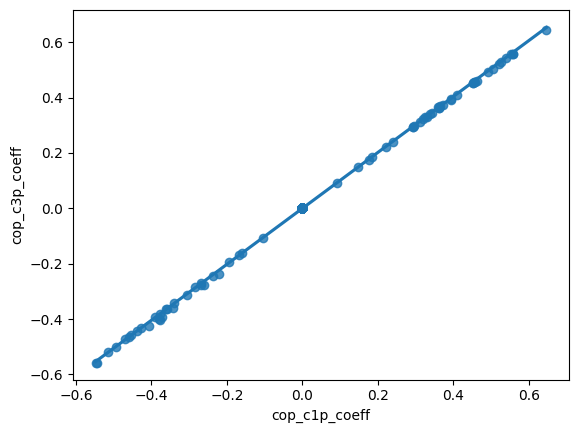

In [317]:
sns.regplot(roi_bucket, x = 'cop_c1p_coeff', y = 'cop_c3p_coeff')

In [318]:
roi_bucket.loc[roi_bucket.cop_c1p_method == 'copula'][['cop_c1p_coeff', 'cop_gmq_coeff']].corr()

,cop_c1p_coeff,cop_gmq_coeff
cop_c1p_coeff,1.0,1.0
cop_gmq_coeff,1.0,1.0


In [219]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)
d2l_neg_area = Parallel(n_jobs=20, verbose=1)(
        delayed(calculate_area)(
            x,
            y,
            _n_array,
            copula_params,
            opt_params
        ) for (x,y,_,_,_n_array) in data_list
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/tmp/ipykernel_1033017/1131232676.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1131232676.py:3: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1131232676.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1131232676.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1131232676.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1131232676.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1131232676.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1131232676.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1131232676.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1131232676.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/

In [220]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)
d2l_other = Parallel(n_jobs=20, verbose=1)(
        delayed(model2.get_d2l_values)(
            x,
            y,
            _n_array,
            _n_array,
            copula_params,
            opt_params
        ) for (x,y,_,_,_n_array) in data_list
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:419: RuntimeWarning: divide by zero encountered in log
  mu_x_start = np.log(x.sum() / umi_sum_1.sum())
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:420: RuntimeWarning: divide by zero encountered in log
  mu_y_start = np.log(y.sum() / umi_sum_2.sum())
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:419: RuntimeWarning: divide by zero encountered in log
  mu_x_start = np.log(x.sum() / umi_sum_1.sum())
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py:419: RuntimeWarning: divide by zero encountered in log
  mu_x_start = np.log(x.sum() / umi_sum_1.sum())
/n/fs/ragr-data/users/hirak/environments/mambaf

In [221]:
def calculate_peak_diff(x,y,n_array,copula_params):
    sx = np.log(x.sum() / n_array.sum())
    sy = np.log(y.sum() / n_array.sum())
    val = model2.only_log_lik(sx,sy,n_array,n_array,x,y,copula_params)
    diff = model2.test_num_local_minima(val)
    return diff

In [222]:
def calculate_peak_diff2(x,y,n_array,copula_params):
    sx = np.log(x.sum() / n_array.sum())
    sy = np.log(y.sum() / n_array.sum())
    val = model2.only_log_lik(sx,sy,n_array,n_array,x,y,copula_params)
    diff = model2.test_num_local_minima(val)
    return diff

In [223]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)
d1l_inflections = Parallel(n_jobs=20, verbose=1)(
        delayed(get_d1l)(
            x,
            y,
            _n_array,
            copula_params,
            opt_params
        ) for (x,y,_,_,_n_array) in data_list
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/tmp/ipykernel_1033017/1571833752.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1571833752.py:3: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1571833752.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1571833752.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1571833752.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1571833752.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1571833752.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1571833752.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1571833752.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/1571833752.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/

In [224]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)
num_peaks = Parallel(n_jobs=20, verbose=1)(
        delayed(get_peak_distance)(
            x,
            y,
            _n_array,
            copula_params,
            opt_params
        ) for (x,y,_,_,_n_array) in data_list
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/tmp/ipykernel_1033017/2848263972.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/2848263972.py:3: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/2848263972.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/2848263972.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/2848263972.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/2848263972.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/2848263972.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/2848263972.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/2848263972.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/2848263972.py:2: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1033017/

IndexError: index 1 is out of bounds for axis 0 with size 1

In [378]:
import importlib
importlib.reload(model2)

<module 'copulacci.model2' from '/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py'>

In [455]:
x,y,_,_,_n_array = data_list[18]
calculate_peak_diff( x,
            y,
            _n_array,
            copula_params)

[0, 0.3736036036036037]

In [185]:
cop_res = [opt_res[i][0] for i in range(len(opt_res))]
results_df.loc[:, 'cop'] = cop_res
results_df.loc[:, 'cop_method'] = [opt_res[i][3] for i in range(len(opt_res))]
results_df.loc[:,'spearman_log'] = spr
results_df.loc[:,'pearson_log'] = prs

In [186]:
results_df['d2l_val'] = d2l_other
results_df.loc[:, 'tot_area'] = d2l_neg_area

In [201]:
results_df.loc[:, 'num_local_optima'] = d1l_inflections
results_df.loc[:, 'peak_diff'] = num_peaks

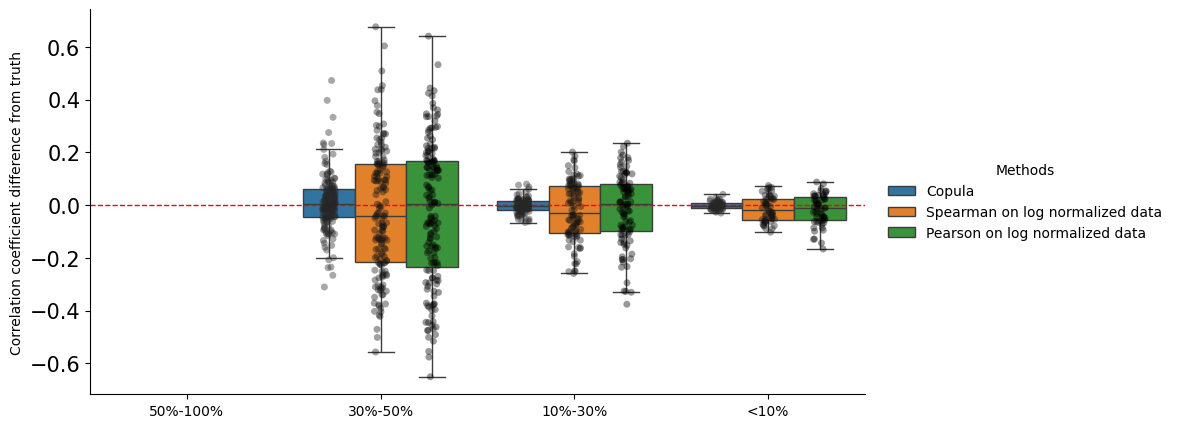

(310, 17)


In [202]:
results_filt = results_df.loc[results_df.d2l_val > 0].copy()
compare_methods(results_filt)
print(results_filt.shape)

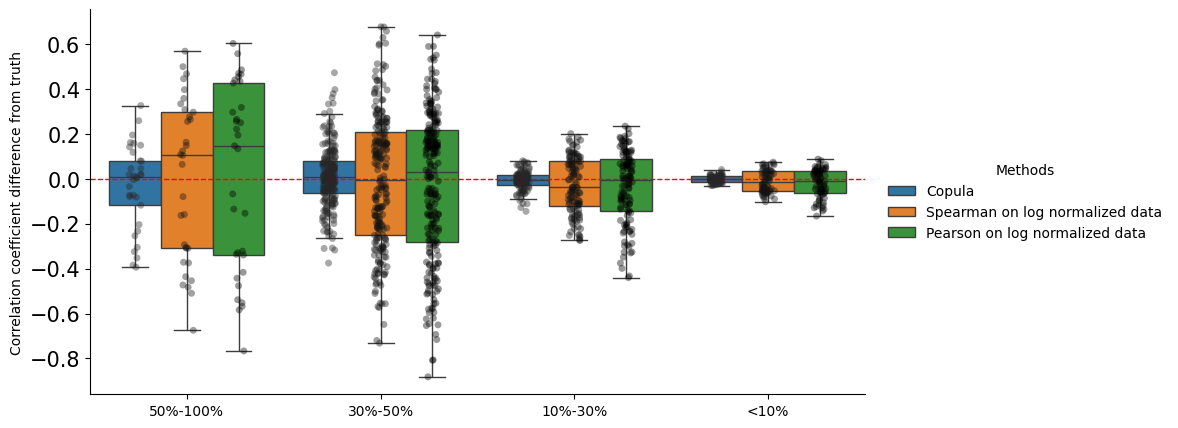

(450, 17)


In [203]:
results_filt = results_df.loc[results_df.num_local_optima==1].copy()
compare_methods(results_filt)
print(results_filt.shape)

In [204]:
tmp = results_filt.loc[results_filt.zr_cat == '50%-100%'].copy()
tmp['cop_diff'] = tmp['rho'] - tmp['cop']

In [205]:
tmp.sort_values(['cop_diff'], ascending=False).head(3)

,orig_index,sparse_frac,mu_x,mu_y,rho,ind,zero_ratio,cop,cop_method,spearman_log,pearson_log,d2l_val,tot_area,num_local_optima,peak_diff,rho_bucket,zr_cat,cop_diff
292,4035,0.5,-10.362811,-10.524481,-0.22,4035,0.742759,-0.546339,copula,-0.060992,-0.085337,-415.719731,-56.527343,1,0.0,10%-30%,50%-100%,0.326339
17,273,0.1,-10.362811,-7.891375,-0.22,273,0.721037,-0.479065,copula,-0.057014,-0.066623,-412.775603,-56.710685,1,0.0,10%-30%,50%-100%,0.259065
167,2323,0.3,-9.865382,-10.524481,-0.44,2323,0.783307,-0.635343,copula,-0.134376,-0.100600,-769.409725,-149.222591,1,0.0,30%-60%,50%-100%,0.195343


In [597]:
importlib.reload(model2)

<module 'copulacci.model2' from '/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/copulacci/model2.py'>

In [598]:
model2.diff_using_num

<function copulacci.model2.diff_using_num(mu_1, mu_2, umi_sum_1, umi_sum_2, x, y, copula_params, opt_params, x_train=None, do_first_order=False)>

In [197]:
def check_lik2(index,ymin=-1000,ymax=50000):
    x,y,_,_,n_array = data_list[index]
    x_train = np.linspace(-0.99, 0.99, 1000)
    lik = []
    likf = []
    d2lik = []
    sx = np.log(x.sum() / n_array.sum())
    sy = np.log(y.sum() / n_array.sum())
    umi_sums_x = n_array
    umi_sums_y = n_array
    # for i in x_train:
    #     likf+=[log_joint_lik_perm(
    #         [i, sx, sy], 
    #         umi_sums_x,
    #         umi_sums_y,
    #         x, 
    #         y, 
    #         perm=1, 
    #         DT=False, 
    #         model = 'copula', 
    #         return_sum = True
    #     )]
    likf = model2.only_log_lik(sx,sy,n_array,n_array,x,y,copula_params)
    d2lik, d1lik = model2.diff_using_num(sx,sy,n_array,n_array,x,y,copula_params,opt_params,x_train=x_train, do_first_order=True)
    
    plt.scatter(x_train, likf, s=3, alpha=0.6, linewidth=0, c='b',label = r'$L$')
    plt.scatter(x_train, d1lik, s=3, alpha=0.6, linewidth=0, c='g',label = r'$\frac{\partial L}{\partial \rho}$' )
    plt.scatter(x_train, d2lik, s=3, alpha=0.6, linewidth=0, c='r',label = r'$\frac{\partial^2 L}{\partial \rho^2}$' )
    plt.axhline(0, color='red', linestyle='--');
    
    plt.ylim(ymin, ymax);
    #plt.xlim(-0.25, 0.25);
    plt.show()
    return (likf, d2lik, d1lik)

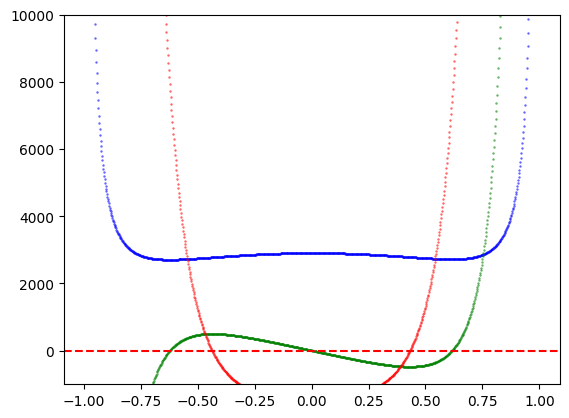

In [198]:
likf, d2lik, d1lik = check_lik2(274, -1000, 10000)

In [757]:
find_peaks(-np.array(d2lik))

(array([5445]), {})

Exception ignored in: <_io.BufferedReader name='/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py", line 221, in get_text_width_height_descent
    def get_text_width_height_descent(self, s, prop, ismath):
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/copulacci/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py", line 221, in get_text_width_height_descent
    def get_text_width_height_descent(self, s, prop, ismath):
OSError: [Errno 116] 

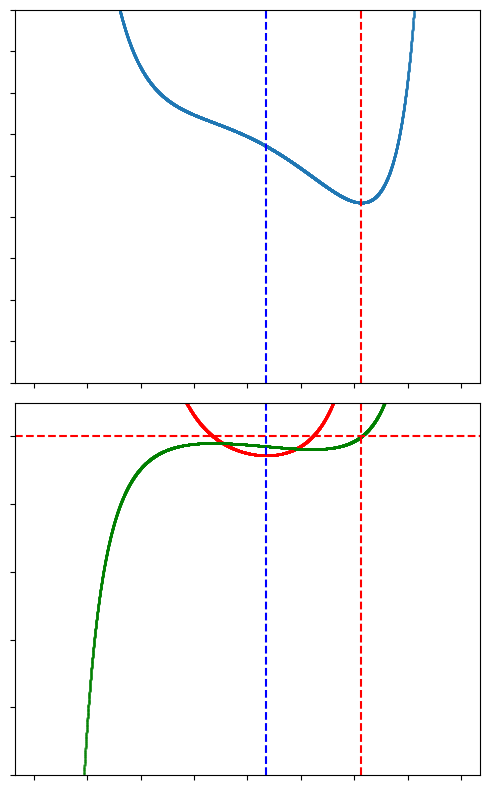

In [759]:
x_train = np.linspace(-0.99, 0.99, 10000)
fig, ax = plt.subplots(2,1,figsize=(5,8),sharex=True)
ax[0].scatter(x_train, likf, s=1, alpha=0.4);
ax[1].scatter(x_train, d2lik, s=1,c='r', alpha=0.4);
ax[1].scatter(x_train, d1lik, s=1,c='g', alpha=0.4);
ax[1].axhline(0, color='red', linestyle='--');
ax[0].axvline(x_train[7691], color='red', linestyle='--');
ax[1].axvline(x_train[7691], color='red', linestyle='--');
ax[0].axvline(x_train[5445], color='blue', linestyle='--');
ax[1].axvline(x_train[5445], color='blue', linestyle='--');
ax[0].set_ylim(5500,6400)
ax[1].set_ylim(-10000,1000)
plt.tight_layout()
plt.show()
#plt.xlim(-0.3,0.0)

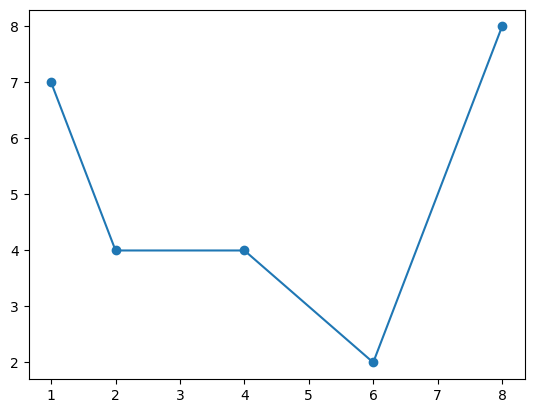

In [614]:
points = np.array([[1,7], [2,4], [4,4], [6,2], [8,8]])
plt.plot(points[:,0], points[:,1],marker='o');

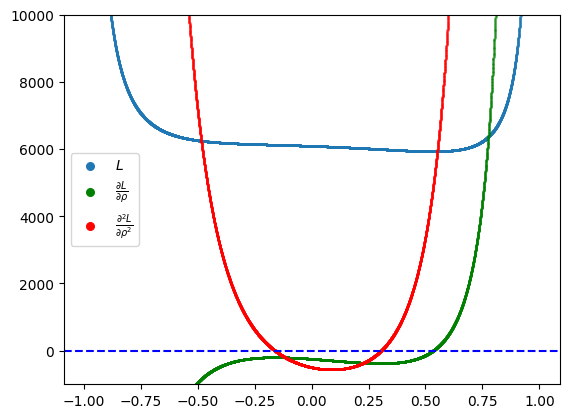

In [608]:
plt.scatter(x_train, likf, s=1, alpha=0.4,label = r'$L$');
plt.scatter(x_train, d1lik, s=1,c='g', alpha=0.4,label = r'$\frac{\partial L}{\partial \rho}$');
plt.scatter(x_train, d2lik, s=1,c='r', alpha=0.4,label = r'$\frac{\partial^2 L}{\partial \rho^2}$');
legend = plt.legend()

# Loop through the legend handles and set the marker size
for handle in legend.legend_handles:
    handle.set_sizes([30])  #
    handle.set_alpha([1])
plt.axhline(0,c='b',ls='--')
plt.ylim(-1000,10000);

In [753]:
s = np.sign(d1lik)
ind_range = np.where(np.r_[s[:-1]!=s[1:], [False]])[0]

In [761]:
ind_range[0]

7691

(-10000.0, 1000.0)

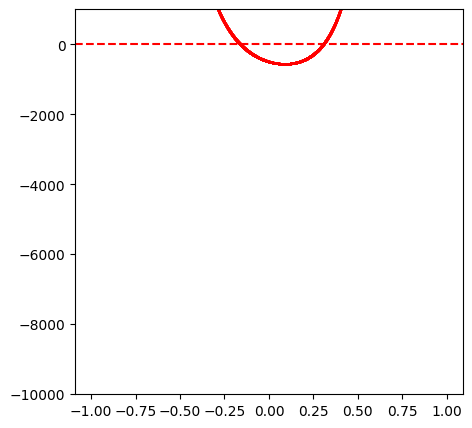

In [568]:
x_train = np.linspace(-0.99, 0.99, 10000)
plt.figure(figsize=(5,5))
plt.scatter(x_train, d2lik, s=1,c='r', alpha=0.4);
plt.axhline(0, color='red', linestyle='--');
plt.ylim(-10000,1000)
#plt.xlim(-0.3,0.0)

In [526]:
from scipy.signal import find_peaks, argrelmin

Peaks: [ 4 12]
Valleys: [8]


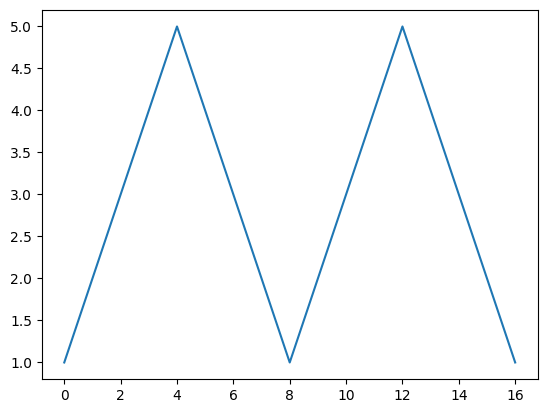

In [554]:
x = np.array([1, 2, 3, 4, 5, 4, 3, 2, 1, 2, 3, 4, 5, 4, 3, 2, 1])

# Find the peaks and valleys
plt.plot(x)
peaks, _ = find_peaks(x, prominence=1)
valleys, _ = find_peaks(-x, prominence=1)

# Print the results
print("Peaks:", peaks)
print("Valleys:", valleys)

In [528]:
argrelmin(np.array(likf))

(array([7691]),)

In [495]:
def find_local_minima(
        mu_1,
        mu_2,
        umi_sum_1,
        umi_sum_2,
        x,
        y,
        copula_params
):
    """
    Take double derivative of the log likelihood function
    """
    DT = copula_params.DT
    lam1 = umi_sum_1 * np.exp(mu_1)
    lam2 = umi_sum_2 * np.exp(mu_2)

    # get z
    r_x = get_dt_cdf(x, lam1, DT=DT)
    r_y = get_dt_cdf(y, lam2, DT=DT)

    z = np.column_stack([r_x, r_y])

    def f(coeff):
        det = 1 - coeff**2
        term1 = np.sum(-0.5 * (((coeff**2)/det) * ((z[:,0]**2) + (z[:,1] ** 2)) - 2 * (coeff/det) * z[:,0] * z[:,1]) )
        term2 = (
            np.sum(np.log( stats.poisson.pmf(x, lam1).clip(EPSILON, 1 - EPSILON) )) +
            np.sum(np.log(stats.poisson.pmf(y, lam2).clip(EPSILON, 1 - EPSILON) ))
        )
        term3 = -0.5 * len(x) * np.log(det+EPSILON)
        logsum = term1+term2+term3
        return -logsum

    left = minimize(f, -0.9, bounds=((-0.999,0.999),),tol=1e-7)
    right = minimize(f, 0.9, bounds=((-0.999,0.999),),tol=1e-7)
    return([left.x[0], right.x[0]])

In [496]:
from scipy.optimize import minimize

In [497]:
x,y,_,_,n_array = data_list[18]
sx = np.log(x.sum() / n_array.sum())
sy = np.log(y.sum() / n_array.sum())
find_local_minima(
    sx,
    sy,
    n_array,
    n_array,
    x,
    y,
    copula_params
)

[0.3732278533447776, 0.373262347330686]

In [491]:
ind[np.argmax(val[ind])]

3

In [683]:
xenium_df = pd.read_csv(
    '/n/fs/ragr-research/users/hirak/Projects/xenium_exploration/output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421/filtered_transcripts.csv'
)

In [669]:
cell_ids = xenium_df.cell_id.unique()

In [670]:
xenium_df.shape

(19061549, 10)

In [671]:
xenium_df.shape

(19061549, 10)

In [672]:
cell_ids[:10]

array(['gdppggcg-1', 'lhaicfbe-1', 'enbabpjg-1', 'enamcpfd-1',
       'enbbmemd-1', 'endgnkla-1', 'enbbpagi-1', 'enbbaleb-1',
       'enbcgpoc-1', 'enbbcedb-1'], dtype=object)

In [679]:
cell_ids_dict = dict(zip(cell_ids,list(range(1,len(cell_ids)+1))))

In [680]:
len(cell_ids)

264564

In [681]:
xenium_df['cell_id'] = xenium_df.cell_id.map(cell_ids_dict)

In [682]:
xenium_df

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance
1295,281603825750324,NaN,0,PTGDS,32.490490,2892.6992,15.553314,40.000000,G4,9.674056
1348,281603825753736,NaN,0,MYLK,31.430653,2893.7126,15.426910,40.000000,G4,9.561960
1460,281663955272109,NaN,0,MYH11,43.882683,2916.5562,15.670197,40.000000,H4,14.415006
1620,281663955302095,NaN,0,BASP1,49.895860,2909.3984,15.569574,40.000000,H4,11.860755
5283,281844343900873,NaN,0,DES,222.787080,5168.9756,16.053940,36.663020,K4,1.653252
...,...,...,...,...,...,...,...,...,...,...
19503885,281960308129826,NaN,0,PTN,8434.291000,6539.0440,23.476469,40.000000,M17,5.875682
19503886,281960308129827,NaN,1,SNCA,8434.750000,6528.9210,17.010150,31.810532,M17,0.000000
19503887,281960308129828,NaN,1,SEMA3C,8438.986000,6528.7383,21.940939,40.000000,M17,0.000000
19503888,281960308129829,NaN,0,DES,8439.412000,6533.2085,28.113586,40.000000,M17,0.321804


In [649]:
xenium_df.loc[]

cell_id
0         442563
263433       895
8919         714
260670       676
78176        667
           ...  
151168         1
36277          1
36276          1
57736          1
115050         1
Name: count, Length: 264565, dtype: int64

In [650]:
xenium_df.shape

(19504112, 10)

In [647]:
xenium_df.to_csv(
    '/n/fs/ragr-research/users/hirak/Projects/xenium_exploration/output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421/filtered_transcripts_renamed.csv',
    index=False
)

In [652]:
def min_xenium_obj(expr_prefix):
    '''
        Create a AnnData object from Xenium experiment folder. Contains only obsm['spatial'] for coordinates.
    '''
    ret = sc.read_10x_mtx(expr_prefix + "/cell_feature_matrix")
    cells = pd.read_csv(expr_prefix + "/cells.csv.gz", compression='gzip')
    assert all(ret.obs_names == cells['cell_id'])
    ret.obsm['spatial'] = cells[["x_centroid", "y_centroid"]].copy().to_numpy()
    return ret

In [696]:
#expr_prefix = '/n/fs/ragr-data/datasets/xenium/washu-xenium-visium/xenium/output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421'

expr_prefix = '/n/fs/ragr-data/datasets/xenium/kanglab-xenium/20240131__034707__20240130_YH_FFPE_2/output-XETG00151__0015913__Region_4__20240131__034751'

In [697]:
adata_xn = min_xenium_obj(expr_prefix)

In [699]:
adata_xn.shape

(301898, 379)

In [691]:
xenium_df = pd.read_csv(
    '/n/fs/ragr-data/datasets/xenium/kanglab-xenium/20240131__034707__20240130_YH_FFPE_2/output-XETG00151__0015913__Region_4__20240131__034751/transcripts.csv.gz',
    compression='gzip'
)

In [700]:
xenium_df.shape

(51116755, 10)

In [701]:
xenium_df = xenium_df.loc[xenium_df.cell_id.isin(adata_xn.obs_names)].copy()

In [702]:
xenium_df.shape

(50544267, 10)

In [703]:
len(xenium_df.cell_id.unique())

301832

In [704]:
cell_ids = xenium_df.cell_id.unique()
cell_ids_dict = dict(zip(cell_ids,list(range(1,len(cell_ids)+1))))
xenium_df['cell_id'] = xenium_df.cell_id.map(cell_ids_dict)

In [706]:
xenium_df.head()

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance
0,281711199911936,1,0,Anxa2,5.653668,2940.6190,15.791547,11.369882,J2,0.937430
1,281711199911945,2,0,Anxa2,5.854890,2928.7937,17.324953,11.831402,J2,2.924843
2,281711199911946,3,0,Anxa2,5.453602,2973.4495,18.172434,6.073180,J2,1.260057
3,281711199911955,4,0,Anxa2,5.512016,2985.4556,15.454571,21.471962,J2,0.651902
4,281711199911956,3,0,Anxa2,5.583851,2975.0410,15.887731,9.736593,J2,0.162988


In [707]:
xenium_df.to_csv(
    #'/n/fs/ragr-research/users/hirak/Projects/xenium_exploration/output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421/filtered_transcripts_renamed.csv',
    expr_prefix + "/filtered_transcripts_renamed.csv",
    index=False
)

In [714]:
transcripts_df = pd.read_csv(
    os.path.join(
        '/n/fs/ragr-research/users/hirak/Projects/xenium_exploration/',
        'output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421',
        'segmentation.csv'
    ))

In [716]:
seg_count_mat_df = pd.read_csv(
    os.path.join(
        '/n/fs/ragr-research/users/hirak/Projects/xenium_exploration/',
        'output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421',
        'segmentation_cell_stats.csv'
    ))

In [722]:
transcript_not_noise_df = transcripts_df.loc[~transcripts_df.is_noise].copy()

In [729]:
filtered_count_df = transcript_not_noise_df[['gene','cell']].groupby(['cell','gene']).size().unstack(fill_value=0)

In [731]:
filtered_count_df.shape

(375448, 377)

In [732]:
adata_xn

AnnData object with n_obs × n_vars = 301898 × 379
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

In [747]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import scipy.io as sio
import subprocess

def write_sparse_mtx(out_dir, matrix, cells, features):
    """Write feature-cell matrix in Seurat/Scanpy-compatible MTX format"""

    # Create the matrix folder.
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    # Convert matrix to scipy's COO sparse matrix.
    sparse_mat = sparse.coo_matrix(matrix)

    # Write matrix in MTX format.
    sio.mmwrite(out_dir + "/matrix.mtx", sparse_mat)

    # Write cells as barcodes.tsv. File name is chosen to ensure
    # compatibility with Seurat/Scanpy.
    with open(out_dir + "/barcodes.tsv", 'w', newline='') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
        for cell in cells:
            writer.writerow(["cell_" + str(cell)])

    # Write features as features.tsv. Write 3 columns to ensure
    # compatibility with Seurat/Scanpy.
    with open(out_dir + "/features.tsv", 'w', newline='') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
        for f in features:
            feature = str(f)
            if feature.startswith("NegControlProbe_") or feature.startswith("antisense_"):
                writer.writerow([feature, feature, "Negative Control Probe"])
            elif feature.startswith("NegControlCodeword_"):
                writer.writerow([feature, feature, "Negative Control Codeword"])
            elif feature.startswith("BLANK_"):
                writer.writerow([feature, feature, "Blank Codeword"])
            else:
                writer.writerow([feature, feature, "Gene Expression"])

    # Seurat expects all 3 files to be gzipped
    subprocess.run("gzip -f " + out_dir + "/*", shell=True)

In [740]:
matrix = filtered_count_df.to_numpy()
cells = filtered_count_df.index.to_list()
genes = filtered_count_df.columns.to_list()

In [748]:
write_sparse_mtx(
    os.path.join(
        '/n/fs/ragr-research/users/hirak/Projects/xenium_exploration/',
        'output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421',
        'baysor_mtx'
    ),
    matrix,
    cells,
    genes
)